<a href="https://colab.research.google.com/github/polina-stepanyan/HW/blob/main/%22%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D0%BD%D0%B8%D1%82%D0%B5%D0%BB%D0%B8%202000-%D1%85%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [261]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict

In [262]:
from typing import Optional, Tuple, List, Dict, Union, Set
import requests
from json.decoder import JSONDecodeError

In [263]:
!pip install razdel
from razdel.substring import Substring
from razdel import sentenize, tokenize

In [264]:
# функция, позволяющая разворачивать вложенные структуры в плоский вид
from itertools import chain

In [265]:
!pip install -U pymorphy2[fast] pymorphy2-dicts-ru
import pymorphy2

Requirement already up-to-date: pymorphy2[fast] in /usr/local/lib/python3.6/dist-packages (0.9.1)
Requirement already up-to-date: pymorphy2-dicts-ru in /usr/local/lib/python3.6/dist-packages (2.4.417127.4579844)


In [266]:
from collections import Counter

In [269]:
!pip install fuzzywuzzy python-Levenshtein
import re
from fuzzywuzzy import fuzz

In [268]:
from tqdm.auto import tqdm
import time
from bs4 import BeautifulSoup

In [270]:
from string import punctuation
import networkx as nx

In [271]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import ngrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [272]:
import seaborn as sns

In [273]:
from sklearn.dummy import DummyClassifier # "глупый" классификтор, возвращающий наиболее частый класс
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupKFold # схема кросс-валидации с группировкой
from sklearn.metrics import accuracy_score

In [274]:
Song = namedtuple('Song', ['id', 'name', 'text', 'views'])
Verse = namedtuple('Verse', ['artist', 'text'])

In [159]:
class Artist:

  def __init__(self, id: int, name: str, songs: List[Song]):
    self.id = id
    self.name = name
    self.songs = songs

    self.top_songs = []
    self.top_words = []
    self.unique_words = []
    self.nunique_words = []
    self.connections = []
    self.top_connections = []

  def __repr__(self):
    header = f"Artist(id={self.id} name={self.name}) \n\nSongs:\n"
    body = '{idx}. Song(id={song.id}, name={song.name}, views={song.views})'
    songs = [
        body.format(idx=idx + 1, song=song) \
        for idx, song in enumerate(self.songs[:5])
    ]
    return header + '\n'.join(song for song in songs)
  
  def add_song(self, song: Song):
    self.songs.append(song)

  def show_connections(self, library: Library) -> List[Artist]:
    if not self.connections:
      connections = library.connections
      connections = list(
          filter(lambda connection: connection[0] == self.id, connections)
      )

      if connections:
        for connection in connections:
          _, j = connection
          self.connections.append(library.get(j))

    return self.connections
  
  def most_frequent_connection(self, library: Library, k: int = 5) -> List[Tuple[Artist, int]]:
    if not self.top_connections:
      self.show_connections(library)
      self.top_connections = Counter(self.connections).most_common(k)
    return self.top_connections
  
  def _get_tokens(self, stemming: bool = False) -> List[str]:
    texts = ''
    for song in self.songs:
      for _, verse in song.text.items():
        
        # Дадим возможность указывать исполнителя как в виде ссылки на класс,
        # так и в виде простого текста. Но так как мы не хотим сайдэффектов
        # (изменения поля Исполнитель в классе куплета после применения данного метода),
        # то проведем сравнение через переменную.
        verse_artist = verse.artist
        if hasattr(verse.artist, 'name'):
          verse_artist = verse.artist.name

        if self.name == verse_artist:
          texts += verse.text.lower()

    tokens = tokenize_text(texts)

    if stemming:
      morph = pymorphy2.MorphAnalyzer(lang='ru')
      tokens = [morph.parse(token)[0].normal_form for token in tokens]
    
    return tokens

  def get_unique_words(self, stemming: bool = False) -> Set[str]:
    if not self.unique_words:
      tokens = self._get_tokens(stemming=stemming)
      self.unique_words = set(tokens)
    return self.unique_words

  def get_nunique_words(self, stemming: bool = False) -> int:
    if not self.nunique_words:
      self.nunique_words = len(self.get_unique_words(stemming=stemming))
    return self.nunique_words
  
  def most_frequent_words(self, k: int = 5, stemming: bool = False) -> List[Tuple[str, int]]:
    if not self.top_words:
      tokens = self._get_tokens(stemming=stemming)
      self.top_words = Counter(tokens).most_common(k)
    return self.top_words

In [275]:
def _extend_to_list(artists: Union[Artist, List[Artist]]) -> List[Artist]:
  if not hasattr(artists, '__len__'):
    artists = [artists]
  return artists


In [161]:
class Library:

  # Optional[Any] == Union[None, Any]
  def __init__(self, artists: Optional[List[Artist]] = None):
    # ОЧЕНЬ ВАЖНО!
    # Словари, листы, кортежи и т.п. нельзя использовать в качестве значений по-умолчанию,
    # т.к. инициализироваться они будут только один раз и любое их изменение в классе/функции
    # будет менять эту изначально созданную копию
    self.artists = artists if artists is not None else []

    self._artist2idx = {}
    self.connections = []

    if self.artists:
      self._artist2idx = {artist.id: idx for idx, artist in enumerate(self.artists)}

  def __repr__(self):
    header = 'Library: \n'
    body = '{idx}. Artist(id={artist.id} name={artist.name})'
    artists = [
        body.format(idx=idx + 1, artist=artist) \
        for idx, artist in enumerate(self.artists[:5])
    ]
    return header + '\n'.join(artist for artist in artists)

  def __getitem__(self, key):
    return self.artists.__getitem__(key)

  def add(self, artists: Union[Artist, List[Artist]]):
    artists = _extend_to_list(artists)
    for artist in artists:
      if artist not in self.artists:
        self.artists.append(artist)
        self._artist2idx[artist.id] = len(self.artists) - 1

  def remove(self, artists: Union[Artist, List[Artist]]):
    artists = _extend_to_list(artists)
    for artist in artists:
      if artist in self.artists:
        self.artists.remove(artist)
    self._artist2idx = {artist.id: idx for idx, artist in enumerate(self.artists)}

  def get(self, id: int) -> Artist:
    artist = None
    idx = self._artist2idx.get(id, None)
    if idx is not None:
      artist = self.artists[idx]
    return artist

  def build_connections(self):
    for primary_artist in self.artists:
      i = primary_artist.id
      for song in primary_artist.songs:
        for _, verse in song.text.items():
          j = verse.artist.id
          if i != j and (i, j) not in self.connections:
            self.connections.append((i, j))

  def clear_cache(self):
        for i in range(len(self.artists)):
            self.artists[i].top_songs = []
            self.artists[i].top_words = []
            self.artists[i].unique_words = []
            self.artists[i].nunique_words = []
            self.artists[i].connections = []
            self.artists[i].top_connections = []

In [138]:
def url_concat(*args: List[str]) -> str:
  return '/'.join(arg[1:] if arg.startswith('/') else arg for arg in args)


def GET(url: str, **kwargs: Dict[str, str]) -> Dict:
  response = requests.get(url, **kwargs)
  if not response:
    raise RuntimeError("API doesn't respond.")
  try:
    response = response.json().get('response', {})
  except JSONDecodeError:
    response = response.content
  return response

In [139]:
class GeniusAPI:

  BEARER: str   = 'Bearer'
  BASE_URL: str = 'https://api.genius.com'

  def __init__(self, token: str):
    self.headers = {
        'Authorization': token if self.BEARER in token else f'{self.BEARER} {token}'
    }

  # Замыкание
  def _concat(self, *args: List[str]) -> str:
    return url_concat(self.BASE_URL, *args)

  def search(self, query: str) -> pd.DataFrame:
    params = {'q': query}
    search_url = self._concat('search')
    response = GET(search_url, params=params, headers=self.headers)

    results = []
    for hit in response.get('hits', []):
      song = hit.get('result', {})
      artist = song.get('primary_artist', {})
      stats = song.get('stats', {})

      result = dict(
          song_id=song.get('id', None),
          song_name=song.get('title', ''),
          artist_id=artist.get('id', None),
          artist_name=artist.get('name', ''),
          views=stats.get('pageviews', 0)
      )
      results.append(result)
    return pd.DataFrame(results)

In [276]:
api = GeniusAPI(token='_mBM3PvBA8P3M8BIvrSFq9O-WhQx_OzDd4yf4i81zI6lPEJjnwVsSDfRmBCpYcCw') #воспользовалась API Артура

In [277]:
api.search('Братья Грим')

,song_id,song_name,artist_id,artist_name,views
0,6106657,Кустурица (Kusturica),1510730,Братья Грим (Brat’ya Grim),0
1,4514293,Ресницы (Eyelashes),1510730,Братья Грим (Brat’ya Grim),0
2,3129547,Outro (Ice),24799,дима бамберг (dima bamberg),6516
3,5036028,Слюни (Slobber),1009318,УННВ (UNNV),5276
4,4086020,И только микрофон (And Only Microphone),1046695,ST,0
5,4479470,Shout out,1154461,​youknownothing,0
6,5024497,Сучки (Bitches),618237,Барто (Barto),0
7,2448157,AWAKE,641895,PROJECT ARGO,0
8,5386982,Марбург (Marburg),2162179,Майк Магни (Mike Magni),0
9,4553017,RAMPAGE,1823274,Ipocrit,0


In [279]:
def get_song_artists(song: Dict) -> List[Tuple[int, str]]:
  artists = []
  song = song['song']
  tmp_artists = [song['primary_artist']] + song['featured_artists']
  for tmp_artist in tmp_artists:
    artists.append((tmp_artist['id'], tmp_artist['name']))
  return artists
  

def get_lyrics(api: GeniusAPI, id: int) -> str:
  id_url = api._concat('songs', f'{id}')
  response = GET(id_url, headers=api.headers)
  artists = get_song_artists(response)

  song_path = response['song']['path']
  song_url = api._concat(song_path).replace('api.', '')

  response = GET(song_url)
  html = BeautifulSoup(response, 'html.parser')
  html = html.find('div', class_='lyrics')

  # Запрос не всегда сразу возвращает полный html
  # Добавим до 10 повторов с 5-ти секундным ожиданием
  increment = 0
  while html is None:
    if increment >= 10:
      break
    time.sleep(5)
    response = GET(song_url)
    html = BeautifulSoup(response, 'html.parser')
    html = html.find('div', class_='lyrics')
    increment += 1
  
  # Тем не менее, даже за 10 попыток полный html может не вернуться
  lyrics = ''
  if html is not None:
    lyrics = html.get_text()

  return artists, lyrics

In [280]:
# Небольшая функция для вытаскивания текста из объектов раздела
def get_text(substring: Substring) -> str:
  return substring.text

In [144]:
def tokenize_text(text: str) -> List[str]:
  # Разбиваем текст на предложения
  sentences = map(get_text, sentenize(text))

  # Разбиваем предложения на подстроки
  substrings = map(tokenize, sentences)

  # Так как генератор подстрок возвращает генераторы
  # Развернем всю эту конструкцию в один генератор
  tokens = map(get_text, chain.from_iterable(substrings))

  # Отфильтруем знаки препинания
  tokens_filtered = filter(lambda token: token not in punctuation, tokens)

  return list(tokens_filtered)

In [281]:
VERSE_REGEXP = r'\[.+\]'
ENG_NAME_REGEXP = r'\s\([A-Za-z\s]+\)'
VERSE_TYPES = [
  'интро',
  'аутро',
  'куплет',
  'припев',
  'предприпев',
  'бридж'
]


def delete_eng_name(name: str) -> str:
  return re.sub(ENG_NAME_REGEXP, '', name)


def compare_names(name1: str, name2: str) -> bool:
  score = fuzz.WRatio(name1, name2)
  return score >= 80


def parse_lyrics(artists: List[Tuple[int, str]], lyrics: str, library: Library) -> Dict[str, Verse]:
  text = {}
  lyrics = lyrics.split('\n\n')
  for part in lyrics:
    key = re.search(VERSE_REGEXP, part)
    if key and any([verse_type in key.group(0).lower() for verse_type in VERSE_TYPES]):
      key = key.group(0)
      part = part.replace(key, '')

      names = artists[0][1]
      if len(artists) > 1:
        if ':' in key:
          key, names = key.split(':')

          names = names.replace(']', '')
          key += ']'
      
      verse_artist = None
      for idx, artist in artists:
        artist = delete_eng_name(artist)
        if compare_names(artist, names):
          verse_artist = library.get(idx)
          if verse_artist is None:
            verse_artist = Artist(id=idx, name=artist, songs=[])
            library.add(verse_artist)
      
      if verse_artist is not None:
        text[key] = Verse(artist=verse_artist, text=part)
  
  return text

In [282]:
def build_library(api: GeniusAPI, queries: List[str]) -> Library:
  library = Library()
  for query in tqdm(queries, leave=False):
    search_result = api.search(query)
    for _, row in search_result.iterrows():
      artists, lyrics = get_lyrics(api, row.song_id)
      text = parse_lyrics(artists, lyrics, library)
      if text:
        song = Song(id=row.song_id, name=row.song_name, text=text, views=row.views)
        for idx, name in artists:
          artist = library.get(idx)
          if artist is not None:
            artist.add_song(song)
  return library

In [294]:
queries = [  
           'Бумбокс',
           'Город 312',
           'Звери',
           'Би-2',
           'Чичерина',
           'МакSим',
           'Виа Гра',
           'Григорий Лепс',
           'Винтаж',
           'Дискотека Авария',
           'Руки Вверх!',
           'Ленинград',
           'Сплин',
           'Братья Грим',
           'Полина Гагарина',
           'Баста',
           'Little Big',
           'Валерий Меладзе',
           'Тимати',
           'Каста'

]

In [295]:
library = build_library(api, queries=queries)

In [296]:
print(library)

Library: 
1. Artist(id=1265811 name=Бумбокс)
2. Artist(id=1265736 name=Город 312 (Gorod 312))
3. Artist(id=49085 name=Баста)
4. Artist(id=2024231 name=Ulukmanapo)
5. Artist(id=2020804 name=AP Clan)


In [297]:
print(library.get(49085))

Artist(id=49085 name=Баста) 

Songs:
1. Song(id=3331861, name=Обернись (Turn around), views=0)
2. Song(id=3050599, name=Сансара (Sansara), views=396755)
3. Song(id=3372511, name=Папа What’s Up, views=90670)
4. Song(id=1861520, name=Мама (Mama), views=80997)
5. Song(id=3332133, name=Солнца не видно (Can’t See the Sun), views=84787)


In [298]:
library.get(49085).most_frequent_words()

[('и', 114), ('я', 77), ('в', 76), ('не', 63), ('на', 45)]

In [299]:
library.build_connections()

TypeError: ignored

In [300]:
library.connections[:10]

[]

In [88]:
G = nx.from_edgelist(library.connections)

In [89]:
G

In [90]:
pg = sorted(nx.pagerank(G).items(), key=lambda x: x[1], reverse=True)
for i, (idx, rank) in enumerate(pg):
  artist = library.get(idx)
  print(f'{i + 1}. {artist.name} имеет PageRank {rank:.3f}')

1. БИ-2 (BI-2) имеет PageRank 0.079
2. Тимати имеет PageRank 0.064
3. Григорий Лепс имеет PageRank 0.043
4. Баста имеет PageRank 0.041
5. Красное Дерево имеет PageRank 0.028
6. Slim имеет PageRank 0.028
7. дима бамберг имеет PageRank 0.028
8. Leon Libre имеет PageRank 0.028
9. Овсянкин имеет PageRank 0.028
10. МС Кальмар имеет PageRank 0.028
11. ВИА Гра имеет PageRank 0.028
12. Валерий Меладзе имеет PageRank 0.028
13. Винтаж имеет PageRank 0.028
14. Елена Корикова имеет PageRank 0.028
15. Жанна Фриске имеет PageRank 0.028
16. Дискотека Авария имеет PageRank 0.028
17. ST имеет PageRank 0.028
18. Ленинград имеет PageRank 0.028
19. Ipocrit имеет PageRank 0.028
20. Chon a luy имеет PageRank 0.028
21. Баста и Смоки Мо (Basta & Smoky Mo) имеет PageRank 0.028
22. Скриптонит имеет PageRank 0.028
23. Елена Темникова имеет PageRank 0.027
24. Bumble Beezy имеет PageRank 0.027
25. Егор Крид имеет PageRank 0.026
26. Скруджи имеет PageRank 0.026
27. Бумбокс имеет PageRank 0.021
28. Город 312 (Gorod 

Визуализация графа

In [91]:
pos = nx.spring_layout(G)
labels = {idx: library.get(idx).name for idx in G.nodes}

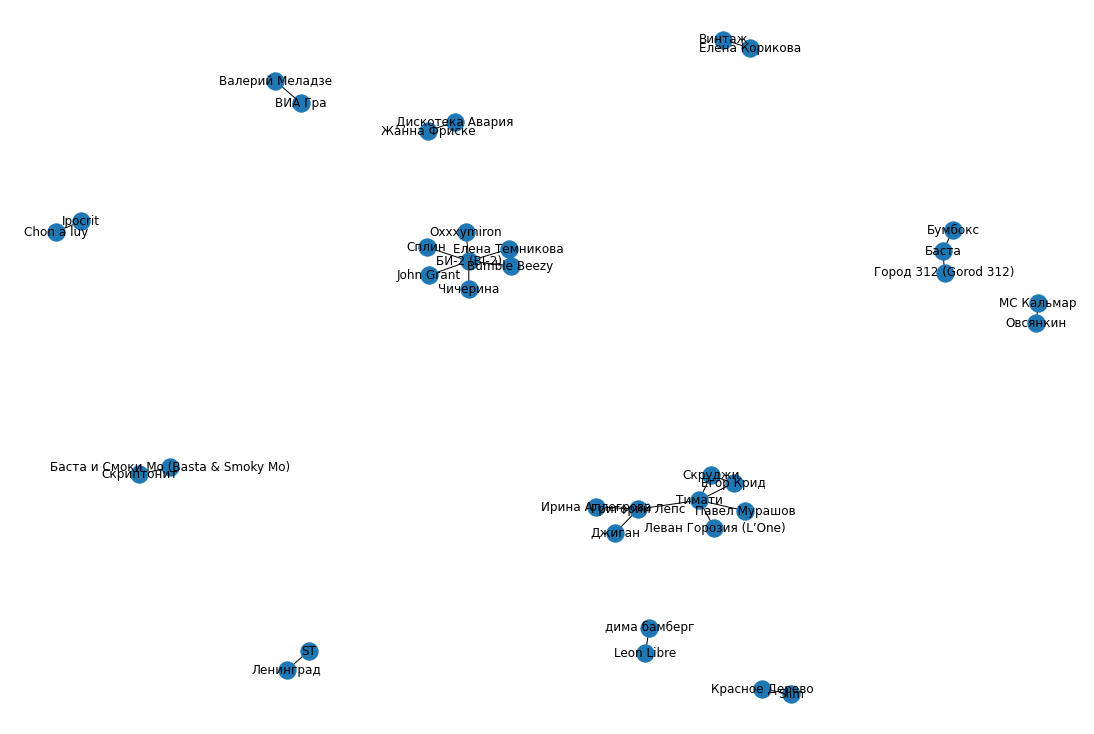

In [94]:
plt.figure(figsize=(15, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos, labels=labels)
plt.show()

Анализ текста

In [110]:
words = defaultdict(lambda: 0)
for artist in library:
  nunique_words = artist.get_nunique_words()
  counter = artist.most_frequent_words(k=nunique_words)
  for word, count in counter:
    words[word] += count

In [113]:
words_sorted = sorted(words.items(), key=lambda x: x[1], reverse=True)
words_sorted[:10]

[('и', 793),
 ('не', 682),
 ('в', 662),
 ('я', 625),
 ('на', 409),
 ('ты', 335),
 ('как', 244),
 ('с', 194),
 ('что', 184),
 ('это', 175)]

In [165]:
library.clear_cache()

AttributeError: ignored

In [174]:
words_after = defaultdict(lambda: 0)
for artist in library:
  nunique_words_after = artist.get_nunique_words(stemming=True)
  counter_after = artist.most_frequent_words(k=nunique_words,stemming=True)
  for word, count in counter_after:
    words_after[word] += count
words_sorted_after = sorted(words_after.items(), key=lambda x: x[1], reverse=True)

Закон Ципфа (Поиск наиболее частых слов в тексте)


In [175]:
ranks: Dict[int, int] = {rank: count for rank, (word, count) in enumerate(words_sorted)}
ranks1: Dict[int, int] = {rank: count for rank, (word, count) in enumerate(words_sorted1)}

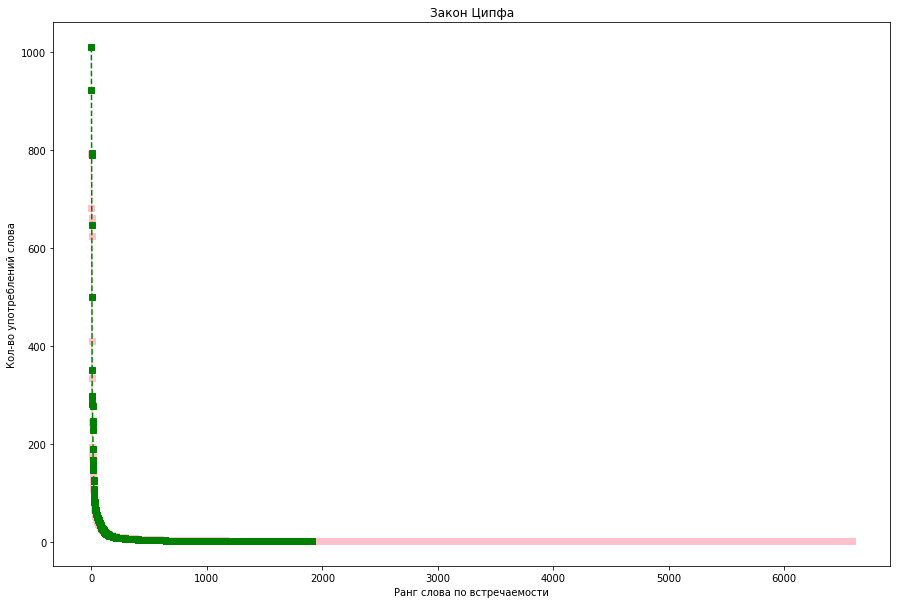

In [168]:
plt.figure(figsize=(15, 10))
plt.title('Закон Ципфа')
plt.plot(list(ranks.keys()), list(ranks.values()), marker='s', linestyle='dashed', color = 'pink')
plt.plot(list(ranks1.keys()), list(ranks1.values()), marker='s', linestyle='dashed', color = 'green')
plt.ylabel('Кол-во употреблений слова')
plt.xlabel('Ранг слова по встречаемости')
plt.show()

Кривая в логарифмической шкале

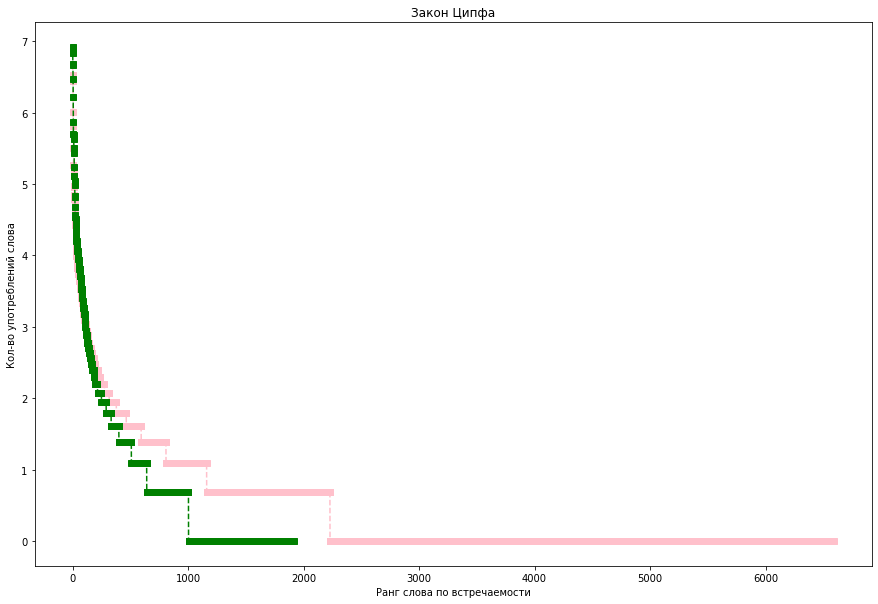

In [176]:
plt.figure(figsize=(15, 10))
plt.title('Закон Ципфа')
plt.plot(list(ranks.keys()), np.log(list(ranks.values())), marker='s', linestyle='dashed', color = 'pink')
plt.plot(list(ranks1.keys()), np.log(list(ranks1.values())), marker='s', linestyle='dashed', color = 'green')
plt.ylabel('Кол-во употреблений слова')
plt.xlabel('Ранг слова по встречаемости')
plt.show()

In [177]:
library.clear_cache()

AttributeError: ignored

Домашнее задание 2. Сравните кривую Ципфа до и после лемматизации. Оцените, насколько уменьшилось кол-во слов и изменились ли топ и антитоп.

In [178]:
print(' Кол-во слов до лемматизации: '+str(sum(list(words.values())))+'\n',
      'Кол-во слов после лемматизации: '+str(sum(list(words_after.values())))+'\n',
     'Топ до и после лемматизации:\n',pd.DataFrame(zip((words_sorted[:10]),(words_sorted_after[:10]))),
     '\n Анти-топ до и после лемматизации:\n',pd.DataFrame(zip((words_sorted[-10:]),(words_sorted_after[-10:]))))

 Кол-во слов до лемматизации: 21589
 Кол-во слов после лемматизации: 17008
 Топ до и после лемматизации:
             0           1
0    (и, 793)   (я, 1011)
1   (не, 682)    (и, 922)
2    (в, 662)   (не, 795)
3    (я, 625)    (в, 790)
4   (на, 409)   (ты, 648)
5   (ты, 335)   (на, 500)
6  (как, 244)   (мы, 351)
7    (с, 194)  (что, 297)
8  (что, 184)  (как, 295)
9  (это, 175)  (всё, 282) 
 Анти-топ до и после лемматизации:
                  0            1
0       (толпы, 1)   (speed, 1)
1      (продаж, 1)     (tag, 1)
2      (бардак, 1)   (damen, 1)
3        (дышу, 1)     (und, 1)
4       (спишь, 1)  (herren, 1)
5  (прочитаешь, 1)    (eine, 1)
6    (грёбаных, 1)    (sehr, 1)
7         (сми, 1)    (gute, 1)
8         (max, 1)     (зер, 1)
9       (speed, 1)    (гута, 1)


Домашнее задание 3. Нарисуйте кривые Ципфа до и после лемматизации в логарифмической и нормальной шкале.

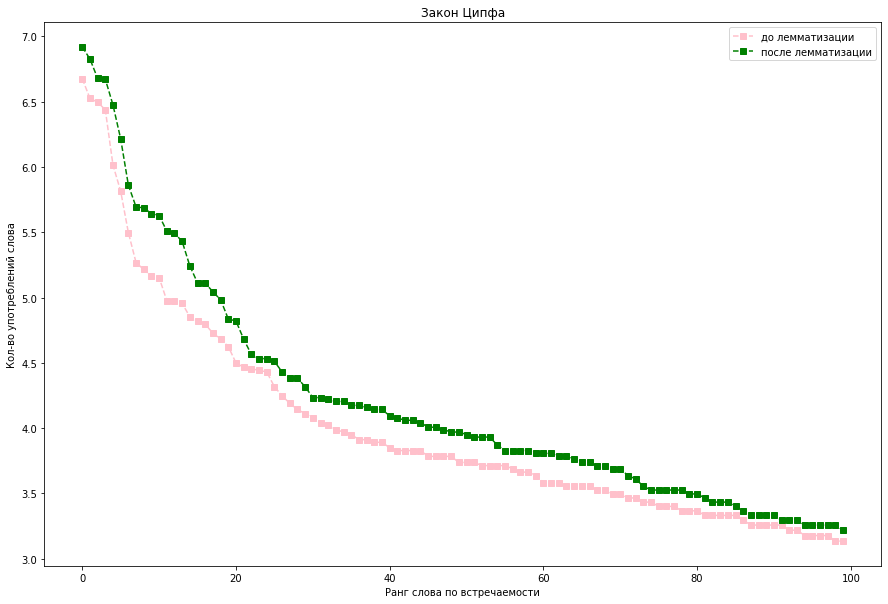

In [179]:
plt.figure(figsize=(15, 10))
plt.title('Закон Ципфа')
plt.plot(list(ranks.keys())[:100], np.log(list(ranks.values()))[:100], marker='s', linestyle='dashed', color = 'pink')
plt.plot(list(ranks1.keys())[:100], np.log(list(ranks1.values()))[:100], marker='s', linestyle='dashed', color = 'green')
plt.legend(labels=['до лемматизации','после лемматизации'])
plt.ylabel('Кол-во употреблений слова')
plt.xlabel('Ранг слова по встречаемости')
plt.show()

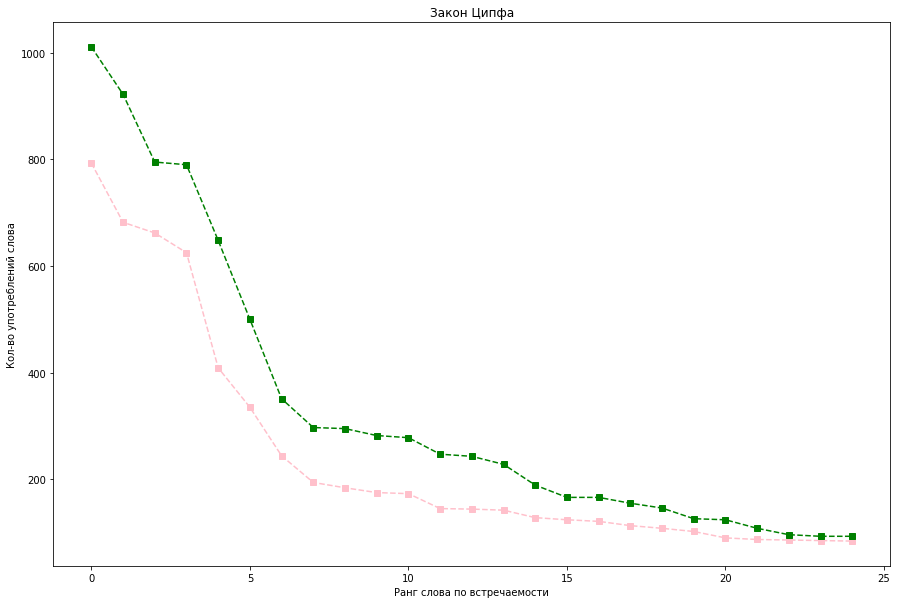

In [180]:
plt.figure(figsize=(15, 10))
plt.title('Закон Ципфа')
plt.plot(list(ranks.keys())[:25], list(ranks.values())[:25], marker='s', linestyle='dashed', color = 'pink')
plt.plot(list(ranks1.keys())[:25], list(ranks1.values())[:25], marker='s', linestyle='dashed', color = 'green')
plt.ylabel('Кол-во употреблений слова')
plt.xlabel('Ранг слова по встречаемости')
plt.show()

In [199]:
prev = None
ranks_diff = []
for count in ranks.values():
  if prev is not None:
    ranks_diff.append(count - prev)
  prev = count

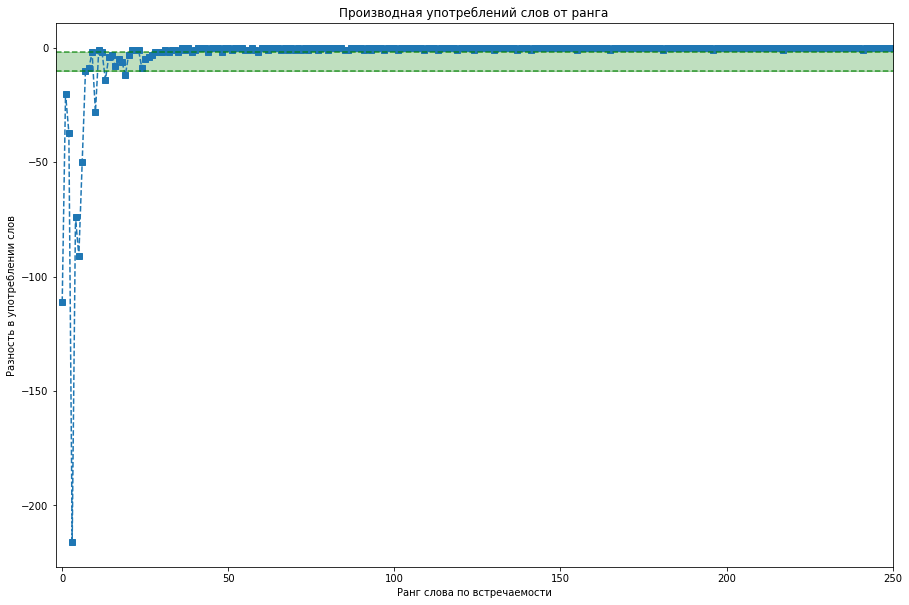

In [200]:
plt.figure(figsize=(15, 10))
plt.title('Производная употреблений слов от ранга')
plt.plot(range(len(ranks_diff)), ranks_diff, marker='s', linestyle='dashed')
plt.axhline(-2, linestyle='dashed', color='g', alpha=.75)
plt.axhline(-10, linestyle='dashed', color='g', alpha=.75)
plt.fill_between(range(-2, 251), [-10] * 253, [-2] * 253, color='g', alpha=.25)
plt.ylabel('Разность в употреблении слов')
plt.xlabel('Ранг слова по встречаемости')
plt.xlim(-2, 250)
plt.show()

In [217]:
words_filtered_diff = {}
for idx, count_diff in enumerate(ranks_diff):
  if -10 <= count_diff <= -2:
    word, count = words_sorted[idx + 1]
    words_filtered_diff[word] = count

In [218]:
print(len(words_filtered_diff))

23


In [219]:
rus_stopwords = stopwords.words('russian')

In [220]:
words_filtered_rule: Dict[str, int] = {word: count for word, count in words_sorted if word not in rus_stopwords and count >= 10}

In [221]:
print(len(words_filtered_rule))

131


In [222]:
print(set(words_filtered_diff.keys()) & set(words_filtered_rule.keys()))

{'–', 'тебе', 'всё', '«', 'это'}


In [211]:
unique_words = set(words_filtered_diff.keys()) | set(words_filtered_rule.keys())

In [223]:
words_filtered_diff = sorted(words_filtered_diff.items(), key=lambda x: x[1], reverse=True)
words_filtered_rule = sorted(words_filtered_rule.items(), key=lambda x: x[1], reverse=True)
ranks_total = pd.DataFrame(unique_words, columns=['word'])
for idx, (word, count) in enumerate(words_filtered_diff):
  mask = ranks_total.word == word
  ranks_total.loc[mask, 'count'] = count
  ranks_total.loc[mask, 'rank_diff'] = idx + 1
for idx, (word, count) in enumerate(words_filtered_rule):
  mask = ranks_total.word == word
  ranks_total.loc[mask, 'count'] = count
  ranks_total.loc[mask, 'rank_rule'] = idx + 1
ranks_total.head()

,word,count,rank_diff,rank_rule
0,–,42.0,22.0,10.0
1,моих,10.0,NaN,129.0
2,свои,14.0,NaN,71.0
3,понять,11.0,NaN,101.0
4,любовь,25.0,NaN,22.0


In [224]:
ranks_total = ranks_total.assign(log_count=np.log(ranks_total.loc[:, 'count']))

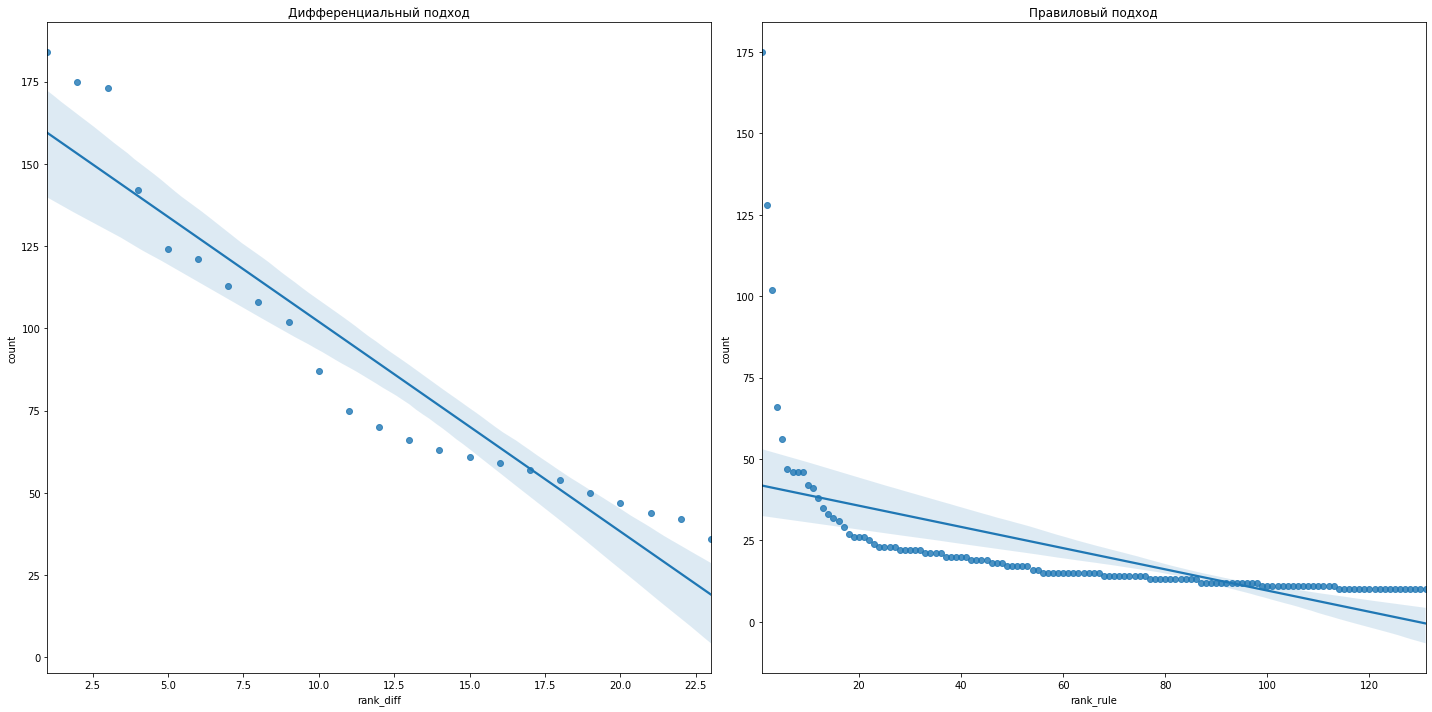

In [226]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Дифференциальный подход')
sns.regplot(x='rank_diff', y='count', data=ranks_total)

plt.subplot(1, 2, 2)
plt.title('Правиловый подход')
sns.regplot(x='rank_rule', y='count', data=ranks_total)

plt.tight_layout()
plt.show()

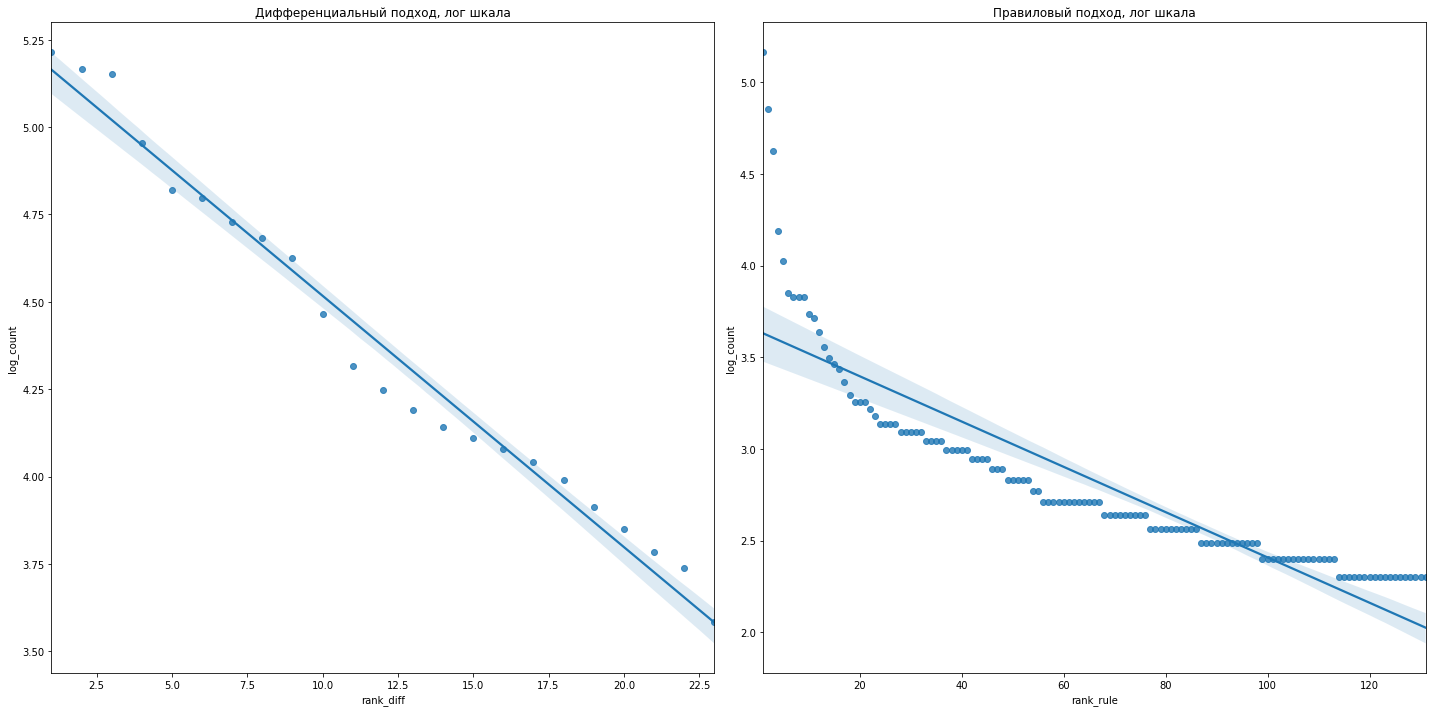

In [227]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Дифференциальный подход, лог шкала')
sns.regplot(x='rank_diff', y='log_count', data=ranks_total)

plt.subplot(1, 2, 2)
plt.title('Правиловый подход, лог шкала')
sns.regplot(x='rank_rule', y='log_count', data=ranks_total)

plt.tight_layout()
plt.show()

In [228]:
text_matrix = pd.DataFrame(columns=['song', 'artist', 'text'])

i = 0
for artist in tqdm(library, leave=False, total=len(library.artists)):
  for song in artist.songs:
    for _, verse in song.text.items():
      text_matrix.loc[i, 'song'] = song.name
      text_matrix.loc[i, 'artist'] = artist.name
      text_matrix.loc[i, 'text'] = verse.text
      i += 1

In [229]:
text_matrix.head()

,song,artist,text
0,Вахтерам (Vahteram),Бумбокс,\nТебе не нравится дым и чёрт с ним\nОн убивае...
1,Вахтерам (Vahteram),Бумбокс,"\nБелые обои, чёрную посуду\nНас в хрущёвке дв..."
2,Вахтерам (Vahteram),Бумбокс,"\nДавай вот так просидим до утра\nНе уходи, по..."
3,Та4то (Ta4to),Бумбокс,"\nТа что была со мной, где ты теперь\nНа друго..."
4,Та4то (Ta4to),Бумбокс,"\nЗнать бы хотя бы где ты, с кем ты\nТепло ли ..."


In [231]:
vocabulary = [word for (word, count) in words_filtered_rule]
n, m = len(text_matrix), len(vocabulary)
# Начнем с обычных счетчиков
tdm = np.zeros(shape=(n, m))
for i, text in enumerate(text_matrix.text):
  for token in tokenize_text(text):
    if token in vocabulary:
      j = vocabulary.index(token)
      tdm[i, j] += 1
tf = tdm / tdm.sum(axis=1).reshape(-1, 1)
tf.sum(axis=1)[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [235]:
idf = np.log(n / (tdm > 0).sum(axis=0))
# Обновим словарь
for i, text in enumerate(text_matrix.text):
  tokens = tokenize_text(text)

  for ngram in ngrams(tokens, n=2):
    if all([token in vocabulary for token in ngram]) and ngram not in vocabulary:
      vocabulary.append(ngram)
  
  for ngram in ngrams(tokens, n=3):
    if all([token in vocabulary for token in ngram]) and ngram not in vocabulary:
      vocabulary.append(ngram)
len(vocabulary)

334

In [236]:
n, m = len(text_matrix), len(vocabulary)

tdm = np.zeros(shape=(n, m))
for i, text in enumerate(text_matrix.text):
  tokens = [token.lower() for token in tokenize_text(text)]

  for token in tokens:
    if token in vocabulary:
      j = vocabulary.index(token)
      tdm[i, j] += 1
  
  for token in ngrams(tokens, n=2):
    if token in vocabulary:
      j = vocabulary.index(token)
      tdm[i, j] += 1

  for token in ngrams(tokens, n=3):
    if token in vocabulary:
      j = vocabulary.index(token)
      tdm[i, j] += 1

# Отфильтруем пустые документы
text_matrix = text_matrix.loc[tdm.sum(axis=1) > 0].reset_index(drop=True)
tdm = tdm[tdm.sum(axis=1) > 0]

# И пустые слова
tdm = tdm[:, tdm.sum(axis=0) > 0]

tf = tdm / tdm.sum(axis=1).reshape(-1, 1)
idf = np.log(n / (tdm > 0).sum(axis=0))

tf_idf = (tf.T * idf.reshape(-1, 1)).T

In [237]:
tf_idf.shape

(592, 334)

In [240]:
#для применения наивного Байессовского метода нужно закодировать исполнителей цифрами
artist2idx = {artist: idx for idx, artist in enumerate(text_matrix.artist.unique())}
idx2artist = {idx: artist for artist, idx in artist2idx.items()}
text_matrix.artist = text_matrix.artist.replace(artist2idx)
text_matrix.head()

,song,artist,text
0,Вахтерам (Vahteram),0,\nТебе не нравится дым и чёрт с ним\nОн убивае...
1,Вахтерам (Vahteram),0,"\nБелые обои, чёрную посуду\nНас в хрущёвке дв..."
2,Вахтерам (Vahteram),0,"\nДавай вот так просидим до утра\nНе уходи, по..."
3,Та4то (Ta4to),0,"\nТа что была со мной, где ты теперь\nНа друго..."
4,Та4то (Ta4to),0,"\nЗнать бы хотя бы где ты, с кем ты\nТепло ли ..."


In [241]:
#оценка работы глупого классификатора
scores_dummy = []
cv = GroupKFold(n_splits=5)
for train_index, test_index in cv.split(X=tf_idf, y=text_matrix.artist, groups=text_matrix.song):
  X_train, X_test = tf_idf[train_index], tf_idf[test_index]
  y_train, y_test = text_matrix.artist.iloc[train_index], text_matrix.artist.iloc[test_index]

  dummy = DummyClassifier(strategy='most_frequent', random_state=42)
  dummy.fit(X_train, y_train)

  y_pred = dummy.predict(X_test)
  scores_dummy.append(accuracy_score(y_test, y_pred))

In [242]:
#наивный байесовский классификатор
scores_nb = []
cv = GroupKFold(n_splits=5)
for train_index, test_index in cv.split(X=tf_idf, y=text_matrix.artist, groups=text_matrix.song):
  X_train, X_test = tf_idf[train_index], tf_idf[test_index]
  y_train, y_test = text_matrix.artist.iloc[train_index], text_matrix.artist.iloc[test_index]

  nb = GaussianNB()
  nb.fit(X_train, y_train)

  y_pred = nb.predict(X_test)
  scores_nb.append(accuracy_score(y_test, y_pred))

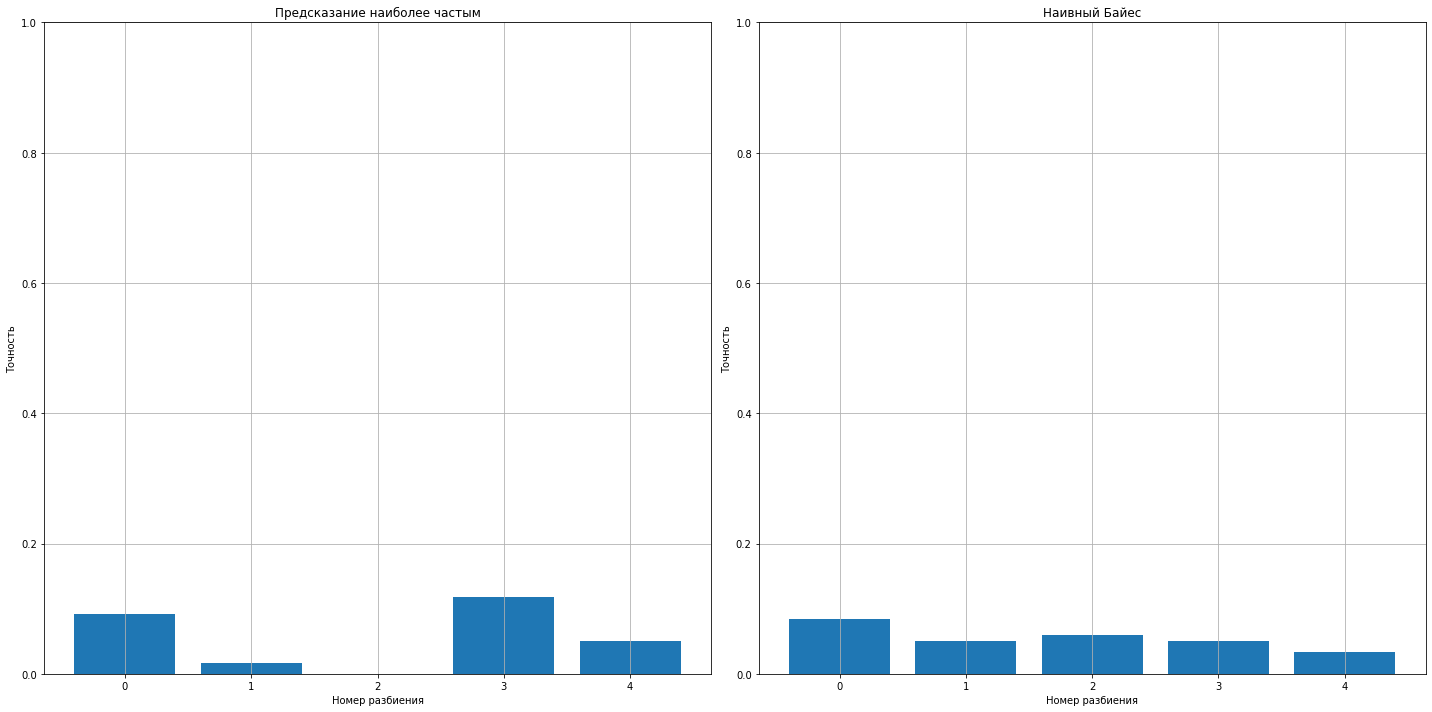

In [243]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Предсказание наиболее частым')
plt.bar(x=range(5), height=scores_dummy)
plt.ylabel('Точность')
plt.xlabel('Номер разбиения')
plt.ylim(0, 1)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Наивный Байес')
plt.bar(x=range(5), height=scores_nb)
plt.ylabel('Точность')
plt.xlabel('Номер разбиения')
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()

Отфильтрую из данных всех, кроме начальных исполнителей

In [245]:
queries = [  
           'Бумбокс',
           'Город 312',
           'Звери',
           'Би-2',
           'Чичерина',
           'МакSим']
queries = [query.lower() for query in queries]
artist2idx = {artist.lower(): idx for artist, idx in artist2idx.items()}
used_artists = [artist2idx[artist] for artist in queries]

AttributeError: ignored

In [246]:
text_matrix = text_matrix.loc[text_matrix.artist.isin(used_artists)]

idx = text_matrix.index
tf_idf = tf_idf[idx]

NameError: ignored

In [247]:
#результат после фильтрации
scores_dummy = []
cv = GroupKFold(n_splits=5)
for train_index, test_index in cv.split(X=tf_idf, y=text_matrix.artist, groups=text_matrix.song):
  X_train, X_test = tf_idf[train_index], tf_idf[test_index]
  y_train, y_test = text_matrix.artist.iloc[train_index], text_matrix.artist.iloc[test_index]

  dummy = DummyClassifier(strategy='most_frequent', random_state=42)
  dummy.fit(X_train, y_train)

  y_pred = dummy.predict(X_test)
  scores_dummy.append(accuracy_score(y_test, y_pred))

scores_nb = []
cv = GroupKFold(n_splits=5)
for train_index, test_index in cv.split(X=tf_idf, y=text_matrix.artist, groups=text_matrix.song):
  X_train, X_test = tf_idf[train_index], tf_idf[test_index]
  y_train, y_test = text_matrix.artist.iloc[train_index], text_matrix.artist.iloc[test_index]

  nb = GaussianNB()
  nb.fit(X_train, y_train)

  y_pred = nb.predict(X_test)
  scores_nb.append(accuracy_score(y_test, y_pred))

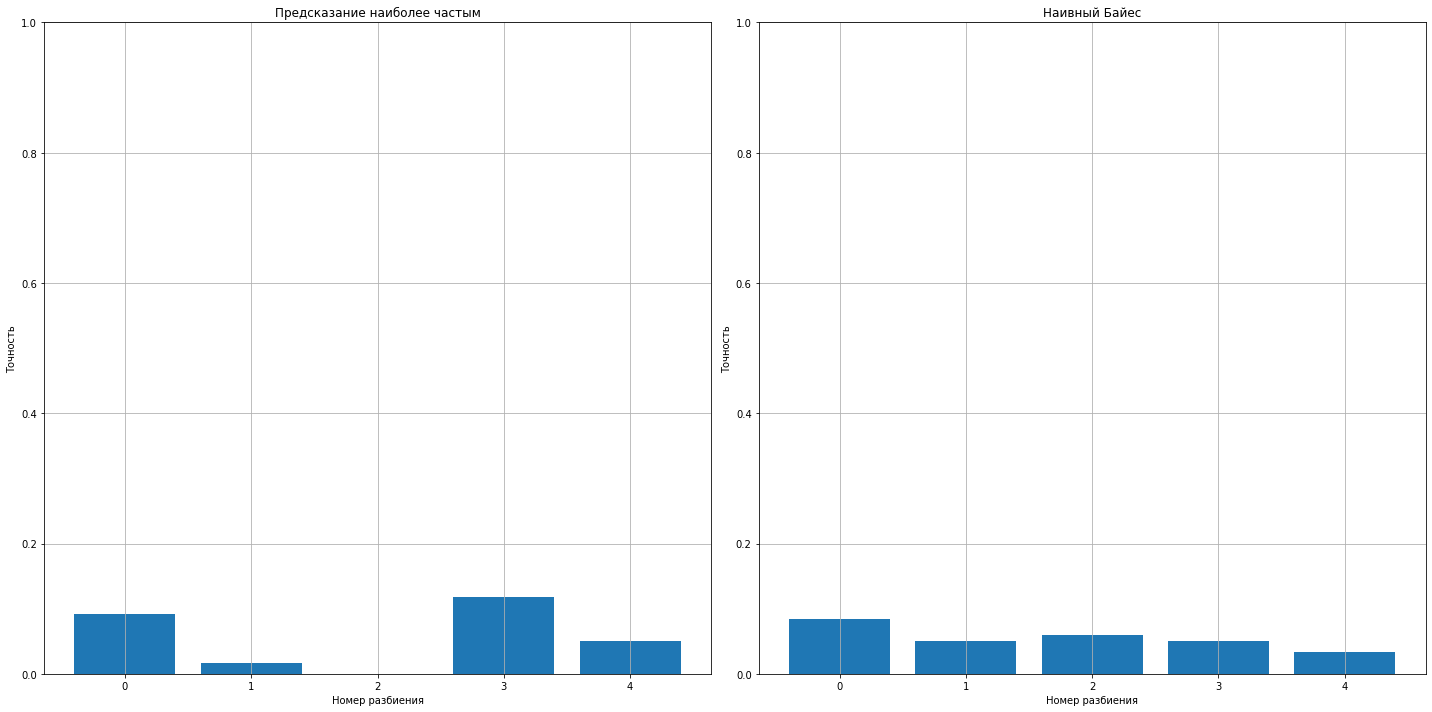

In [248]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title('Предсказание наиболее частым')
plt.bar(x=range(5), height=scores_dummy)
plt.ylabel('Точность')
plt.xlabel('Номер разбиения')
plt.ylim(0, 1)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('Наивный Байес')
plt.bar(x=range(5), height=scores_nb)
plt.ylabel('Точность')
plt.xlabel('Номер разбиения')
plt.ylim(0, 1)
plt.grid()

plt.tight_layout()
plt.show()